# Project 1 : Poisson process simulation

Group of students :
- Meriem Naji
- Wissal Belhorma


$\textcolor{green}{\text{Context}}$

Imagine that we have events we describe by a point process $N$.

At the beginning of the observation, events occur according to a Poisson process intensity $\lambda_0$ until a time $\tau$ and then switch to a new regime which is still a Poisson process but with intensity $\lambda_1$.

We suppose that we know $\lambda_0$ and $\lambda_1$ but not $\tau$.

We still know that $\tau$ follows an exponential distribution of parameter $\sigma$.

We want to estimate $\tau$
 by the observation of a single trajectory.

We denote by $Ft=\sigma(N(s), s≤t)$ the $\sigma$-field which contains the information given by the trajectory up to time $t$. We set $\hat{Z}(t)=P(\tau≤t|Ft)$

We have (or we should have) shown that
$\hat{Z}(t)=\int_0^t h(s)(1−\hat{Z}(s)) ds + \int_0^t\frac{(b−a)\hat{Z}(s^−)(1−\hat{Z}(s^−))}{\hat{λ}(s)}(dN(s)−\hat{λ}(s) ds)$

$\textcolor{green}{\text{Work}}$

1) From the last equation, describe the dynamics of $\hat{Z}$ between its jumps and give the size of its jumps.
2) Simulate a sample path of $N$ and then the correse_intervalponding trajectory of $\hat{Z}$.
3) Suppose that $\hat{Z}$ is the true observation, what is a criterion to estimate $\tau$ ?
4) Open question : which technique(s) of data analysis could be used to answer the same question with or without the Poisson hypothesis ? To get an hint of the performance, give it a ty on the Poisson situation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.integrate as integrate
import scipy
from scipy.signal import hamming , savgol_filter
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
import scipy.optimize as optimize
from sklearn.neighbors import KernelDensity





#### Question 1 :

We have  $\hat Z(t)=\mathbf P(\tau\le t | \mathcal F_t)$ the conditional probability of the first jump time $\tau$ of the Poisson process.


Besides , using the question 9 of the exercice 2.6 of the poly , we can write $\hat Z(t) $ as

$$
\begin{equation}
   \widehat{Z}(t)=\int_{0}^{t}h(s)(1-\hat{Z}(s))\ d s
   +\int_{0}^{t }
   \frac{(b-a)\widehat{Z}(s^{-})(1-\widehat{Z}(s^{-}))}{\hat\lambda(s)}\Bigl(
   \ d N(s) -\hat\lambda(s) \ d s \Bigr)
 \end{equation}
$$

with $h(s)=\frac{f(s)}{1-F(s)}$ and $\hat\lambda(s)= \mathbb E[\lambda | \mathcal F_s]$ and $a,b$ are the bounds of the intensity $\lambda$.

So to describe the dynamic of $\hat Z$ between its jumps we can write :

$$ \widehat{Z}(t) - \widehat{Z}(T_{n-1}) = \int_{T_{n-1}}^{t}(h(s) - (b-a)\widehat{Z}(s))(1-\widehat{Z}(s))\ d s$$

Then $\widehat{Z}(t)$ between the jumps of the process is the solution of the differential equation :

$$ y'(t) = (h(t) - (b-a)y(t))(1-y(t)) $$

with $y(T_{n-1}) = \widehat{Z}(T_{n-1})$

Furthermore, to determine the size of the jumps, we can express the second term in the equation, which describes the size, as follows:

$$\int_{0}^{t}(b-a)\widehat{Z}(s^{-})(1-\widehat{Z}(s^{-}))λ(s)(dN(s)−λ(s)ds)\int_{0}^{t }​λ(s)(b-a)\widehat{Z}(s^{-})(1-Z(s^{-}))​(dN(s)−λ(s)ds)$$
This indicates that the size of the jumps is determined by the adjustment based on the observed trajectory.

hence The size of the jumps is given by:
 $$ \hat Z(T_n) - \hat Z(T_n^-) = \frac{(b-a) \hat Z(T_n^-)(1 - \hat Z (T_n^-))}{a+ (b-a) \hat Z(T_n^-)} $$


#### Question2 :   


***Simulation of $N$***

To simulate $N$ in interval  $[0, T]$ we start by :


**Generate $\tau$**

$\tau$ follows an exponential distribution with parameter $\sigma$, so we can generate $\tau$ using the inverse transform sampling method:
$\
\tau = -\frac{1}{\sigma} \ln(U). $

where $ U \sim \text{Uniform}(0, 1)  $

**Simulate Events for $N_a$:**


Simulate the jump times of $N_a$ (the Poisson process with intensity $\lambda_0$ ) starting from 0 and continuing as long as the jump times do not exceed $\tau$

**Simulate Events for $N_b$:**


Simulate the jump times of $N_b$ (the Poisson process with intensity $\lambda_1$ ) starting from $\tau$ and continuing as long as the jump times do not exceed $T$

In [2]:
def processus_poisson(lam, T):
    # Generate the number of events N that occur in time period T
    N = np.random.poisson(lam * T)
    t = np.sort(np.random.uniform(0, T, N))
    return N, t


In [3]:
# Concatenation of two poisson processes

def concatenate(process1 , process2):
    newtimes = np.concatenate((process1[1], process2[1]+process1[1][-1]))
    newevents = process1[0] + process2[0]
    return (newevents, newtimes)


def combined_process(a, b, lamb, T):
    tau = stats.expon.rvs(scale=1/lamb)
    process1 = processus_poisson(a, tau)
    process2 = processus_poisson(b, T-tau)
    return concatenate(process1, process2) , tau
    # ignore IndexError

In [4]:

# Plotting
def plot_process(N, t, disruption=0):
    # disruption : time of disruption tau
    plt.figure(figsize=(15, 2))
    plt.plot(t, np.zeros(N), '|', label='N')
    if disruption != 0:
        plt.plot([disruption, disruption], [-1, 1], 'r', label=r'$\tau$')
    plt.xlabel('Time')
    plt.ylabel('Number of events')
    plt.title('simulation of poisson process with disruption')
    plt.axis('off')
    plt.legend()
    plt.show()

In [5]:
# Here we calibrate our process:
lambda1 = 0.1
T = 20
a = 10
b = 5

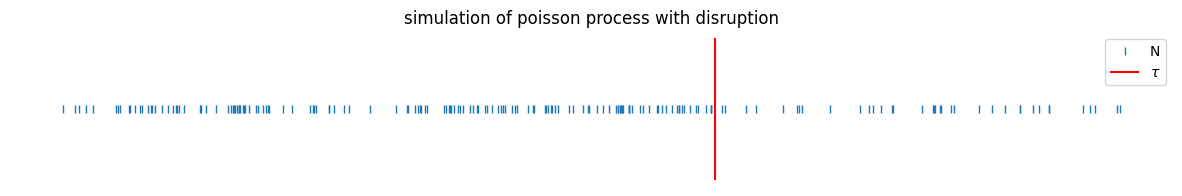

True tau :  12.074562335856063


In [6]:
time_interval, tau = combined_process(a, b , lambda1 , T)
plot_process(*time_interval , disruption=tau)
print("True tau : ", tau)

**Remark**

if you had error index out of range just rerun the notebook

***Simulation of trajectory    $\widehat{Z}(t)$***

To simulate the trajectory of  $\widehat{Z}(t)$ we solve  the differential equation :

$$ y'(t) = (h(t) - (b-a)y(t))(1-y(t)) $$

with $y(T_{n-1}) = \widehat{Z}(T_{n-1})$


then we We start by generating τ from an exponential distribution with parameter σ. Next, we simulate the event process N(t)


For each arrival time, we iteratively solve the differential equation using numerical integration methods such as scipy.integrate.solve_ivp, updating (t) based on the events observed in N(t).

Finally, we plot the trajectory of
$\widehat{Z}(t)$ over the given time interval to visualize its evolution.

In [7]:

n = 100
times = time_interval[1]

def h(t):
    ft = stats.expon.pdf(t, scale = 1/lambda1)
    Ft = stats.expon.cdf(t, scale = 1/lambda1)
    result = ft/(1-Ft)
    return result

def f(t,y):
    return (h(t) - (b-a)*y)*(1-y)

def solve(times, n, a, b):

    Times = np.array([0])
    Z = np.array([integrate.quad(h, 0, times[0])[0]])


    for i in range(1, len(times)-1) :
        z0 = Z[-1] + (b-a)*Z[-1]*(1-Z[-1])/(a+(b-a)*Z[-1])


        sol = scipy.integrate.solve_ivp(f, [times[i-1], times[i]], [z0], t_eval=np.linspace(times[i-1], times[i], n))
        t = sol.t
        z = sol.y
        Times = np.concatenate((Times, t))
        Z = np.concatenate((Z, z[0]))

    return Times , Z

Times , Z = solve(times, n, a, b)

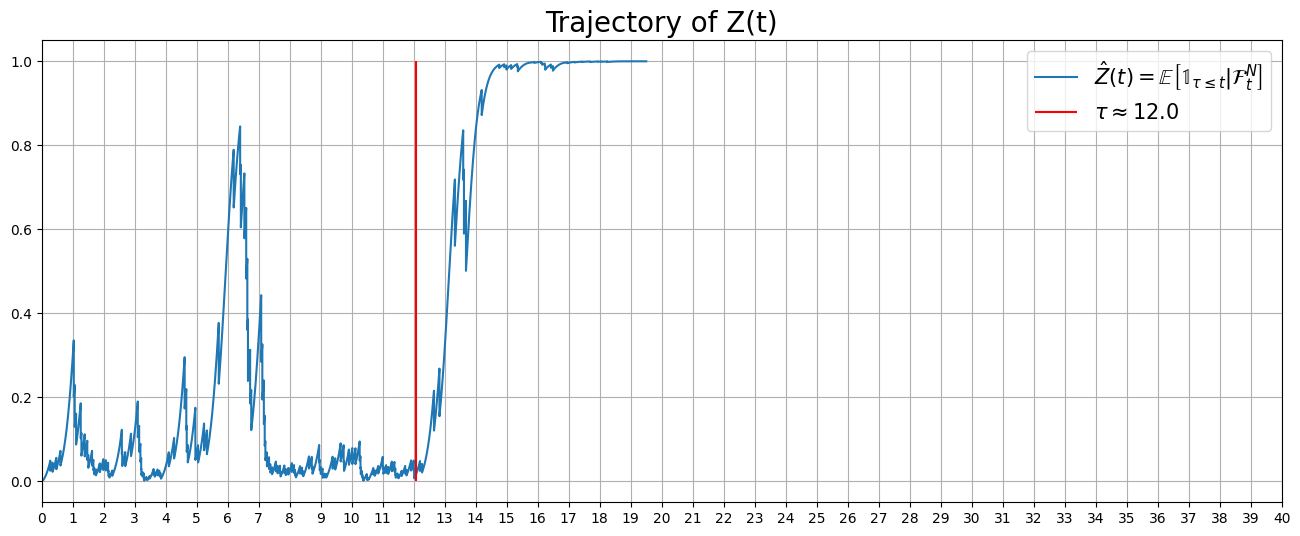

In [8]:
def plot_trajectory(ts, z, tau, end=100):
    #Plots the graph of the process Z hat

    plt.figure(figsize=(16, 6))
    plt.plot(ts, z, label=r'$\hat{Z}(t) = \mathbb{E}\left[\mathbb{1}_{\tau \leq t}|\mathcal{F}^N_t\right]$')
    plt.xticks(range(end + 1))
    if tau <= end:
        plt.vlines(tau, 0, 1, color='r', label=rf'$\tau \approx $' + str(tau)[:4])
    else:
        plt.vlines(0, 0, 0, color='r', label=rf'$\tau \approx $' + str(tau)[:4])
    plt.legend(fontsize=15)
    plt.grid()
    plt.title(rf"Trajectory of Z(t)", fontsize=20)
    plt.xlim(0,40)
    plt.show()
plot_trajectory(Times, Z, tau)

Based on the curve, we observe that before $\tau$, there are irregularities due to the random nature of the data. However, after $\tau$, the slope becomes steeper, and one time unit later, we obtain a nearly constant result of 1. This suggests a significant change in the underlying process at $\tau$, transitioning from a more variable state to a more stable state characterized by a consistent outcome.

#### Question 3:

$\textcolor{orange}{\text{First Idea : the Maximum Likelihood Estimation (MLE) approach}}$


$\text{The log-likelihood function is defined as: }$
$$\log L(\tau) = \sum_{i: t_i \leq \tau} \log(\lambda_0) - \lambda_0 \tau + \sum_{i: t_i > \tau} \log(\lambda_1) - \lambda_1 (T - \tau)$$

**Fonction  Log-Vraisemblance**

The log-likelihood function captures the probability of observing the event times given the Poisson intensities $ \lambda_0$ and $\lambda_1$, as well as a changepoint $ \tau$.

**Maximization of the Log-Likelihood Function**

By maximizing this function, we find $\tau$ that makes the observed data most probable under the assumed model. This $\tau$ is our estimate of the changepoint.






In [9]:

def log_likelihood(tau_0, times, lambda_0, lambda_1, T1):
    before_tau = times[times <= tau_0]
    after_tau = times[times > tau_0]
    logL = len(before_tau) * np.log(lambda_0) - lambda_0 * tau_0 + len(after_tau) * np.log(lambda_1) - lambda_1 * (T1 - tau_0)
    return -logL  #  we need here to minimize, so we use the negative log-likelihood

result = optimize.minimize_scalar(log_likelihood, bounds=(0, T), args=(times, a, b, T), method='bounded')
tau_est = result.x



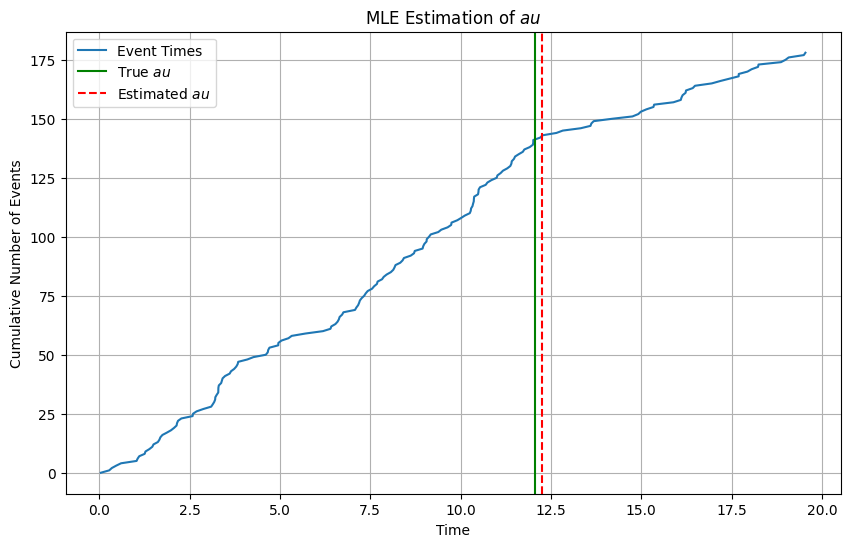

True tau: 12.074562335856063
Estimated tau: 12.267902811743921


In [10]:
# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(times, np.arange(len(times)), '-', label='Event Times')
ax.axvline(x=tau, color='g', linestyle='-', label='True $\tau$')
ax.axvline(x=tau_est, color='r', linestyle='--', label='Estimated $\tau$')
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative Number of Events')
ax.set_title('MLE Estimation of $\tau$')
ax.legend()
ax.grid(True)
plt.show()

print(f"True tau: {tau}")
print(f"Estimated tau: {tau_est}")

**we remark that the randomness affect our results, in fact  $\textcolor{green}{\text{we have one out of four }}$ the correct result between the true $\tau$ and the estimated $\tau$**

**We notice that when  the total observation duration $T$ is relatively large ( ex: $T=100$),  the difference between the true value of ττ and the estimated value of $\tau$ becomes significant , and this because several raisons :  Low Event Density , Edge Effects ...**

$\textcolor{orange}{\text{Second Idea :Using Filters approach }}$

An alternative method to estimate ττ involves using filters to smooth the observed trajectory of $\hat Z(t)$. By applying filters such as $\textbf{the Hamming filter}$ or the $\textbf{Savitzky-Golay filter}$, we can reduce noise and extract meaningful features, potentially aiding in the detection of the change point $\tau$

In [11]:
Z_filtered_hamm = np.convolve(Z, hamming(100)/sum(hamming(100)), mode='same')  # Hamming filter
Z_filtered_savgol = savgol_filter(Z, 400, 3)  # Savitzky-Golay filter


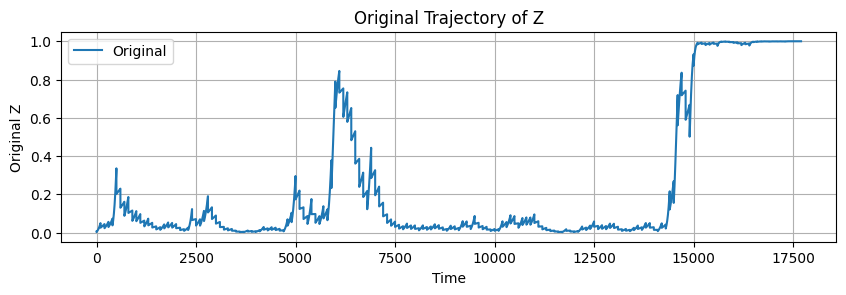

In [12]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(Z, label='Original')
plt.xlabel('Time')
plt.ylabel('Original Z')
plt.title('Original Trajectory of Z')
plt.legend()
plt.grid(True)

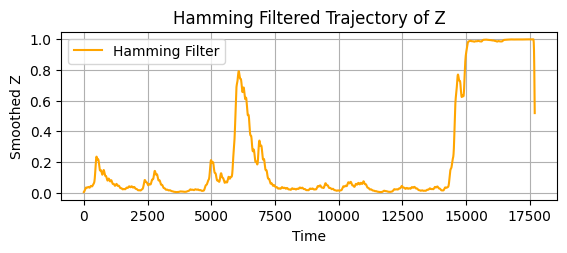

In [13]:
plt.subplot(2, 1, 2)
plt.plot(Z_filtered_hamm, label='Hamming Filter', color='orange')
plt.xlabel('Time')
plt.ylabel('Smoothed Z')
plt.title('Hamming Filtered Trajectory of Z')
plt.legend()
plt.grid(True)

plt.show()

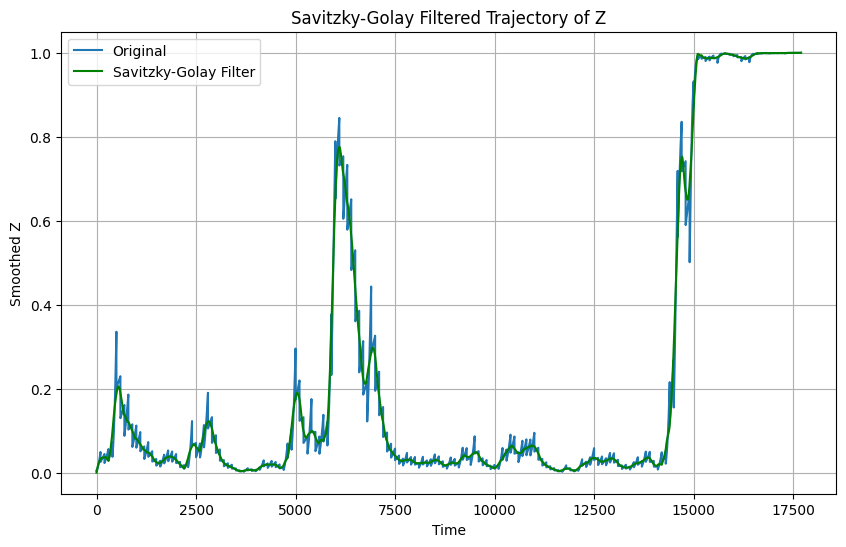

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(Z, label='Original')
plt.plot(Z_filtered_savgol, label='Savitzky-Golay Filter', color='green')
plt.xlabel('Time')
plt.ylabel('Smoothed Z')
plt.title('Savitzky-Golay Filtered Trajectory of Z')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
print('Estimated Tau from original Z' , Times[np.where(Z > 0.5)[0][0]])
print('Estimated Tau from Hamming filter' , Times[np.where(Z_filtered_hamm > 0.5)[0][0]])
print('Estimated Tau from Savitzky-Golay filter' , Times[np.where(Z_filtered_savgol > 0.5)[0][0]])

Estimated Tau from original Z 5.9397373691691175
Estimated Tau from Hamming filter 5.9397373691691175
Estimated Tau from Savitzky-Golay filter 5.934869193176652


the Hamming filter, which is designed to reduce noise with minimal distortion of the signal, effectively preserves the characteristics of the original data. In contrast, the Savitzky-Golay filter, which smooths data by fitting successive polynomials, estimates $\tau$ less accurate than the true value. This slight overestimation can be attributed to the filter’s tendency to smooth over sharp transitions, making it less sensitive to the exact change point but useful for capturing broader trends. Thus, while the Hamming filter maintains accuracy in detecting $\tau$, the Savitzky-Golay filter provides a smoother but slightly delayed estimate

#### Question 4:


$\textcolor{orange}{\text{KDE estimation}}$

We will  use $\textcolor{pink}{\text{Kernel Density Estimation }}$ to estimate the density of event times. The kde_estimation function fits a KDE model to the data and returns the estimated density.


We will regenerate data and change the parameters so that we have a good result otherwise the method gives an estimation of tau far from the true value

In [16]:


# Generate synthetic data with a change point
np.random.seed(42)

def generate_data(T, change_point, rate1, rate2):
    times1 = np.cumsum(np.random.exponential(scale=1/rate1, size=int(change_point*rate1)))
    times2 = np.cumsum(np.random.exponential(scale=1/rate2, size=int((T-change_point)*rate2)))
    if times1.size > 0:
        times2 += times1[-1]
    times = np.concatenate((times1, times2))
    times = times[times < T]
    return times

# Parameters
T = 100 # Total time

rate1 = 1  # Rate before change point
rate2 = 5 # Rate after change point

# Generate data
times = generate_data(T, tau, rate1, rate2)

# KDE estimation
def kde_estimation(times, bandwidth=1.0):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(times[:, np.newaxis])
    log_dens = kde.score_samples(np.linspace(0, T, 1000)[:, np.newaxis])
    return np.exp(log_dens), kde

# Estimate KDE density
density_estimation, kde = kde_estimation(times, bandwidth=1.0)

# Calculate the derivative of the density estimate
time_points = np.linspace(0, T, 1000)
density_derivative = np.gradient(density_estimation, time_points)

# Smooth the derivative to reduce noise
smoothed_derivative = np.convolve(density_derivative, np.ones(10)/10, mode='same')

# Find the point with the highest rate of change in the smoothed derivative
estimated_tau = time_points[np.argmax(np.abs(smoothed_derivative))]



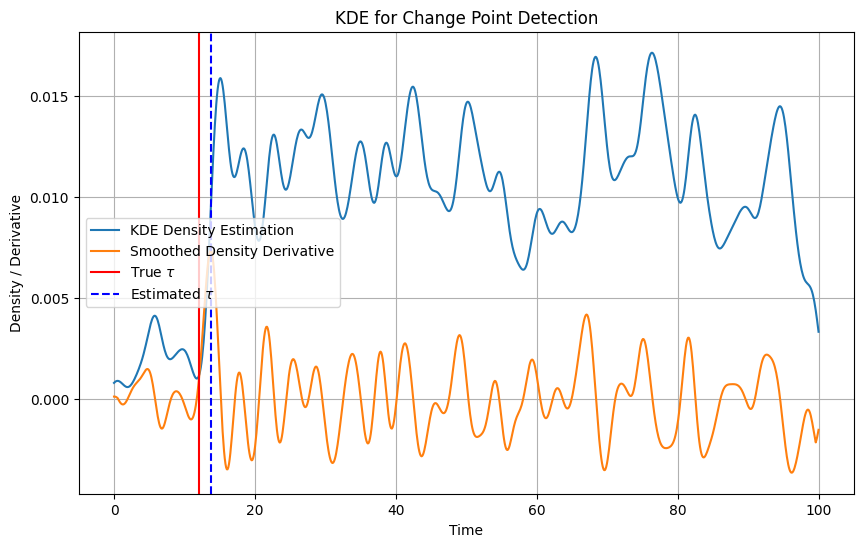

True change point (tau): 12.074562335856063
Estimated change point (tau): 13.713713713713714


In [17]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time_points, density_estimation, label='KDE Density Estimation')
plt.plot(time_points, smoothed_derivative, label='Smoothed Density Derivative')
plt.axvline(x=tau, color='r', linestyle='-', label=r'True $\tau$')
plt.axvline(x=estimated_tau, color='b', linestyle='--', label=r'Estimated $\tau$')
plt.xlabel('Time')
plt.ylabel('Density / Derivative')
plt.title('KDE for Change Point Detection')
plt.legend()
plt.grid(True)
plt.show()

print("True change point (tau):", tau)
print("Estimated change point (tau):", estimated_tau)

We notice that sometimes we have a result close to the true value and sometimes is far , this is due to issues such as suboptimal bandwidth selection, high noise levels, or uneven data distribution. In these cases, the KDE might smooth over the actual change point .

$\textcolor{orange}{\text{Method of K-Means clustering }}$

We prepare a dataset of event times and their inter-arrival times, and we apply K-Means clustering, we identify two clusters corresponding to the different regimes. The transition between these clusters indicates the estimated $\tau$.
 This method leverages the ability of K-Means to detect changes in data distribution, effectively pinpointing the change-point $\tau$ in the Poisson process.

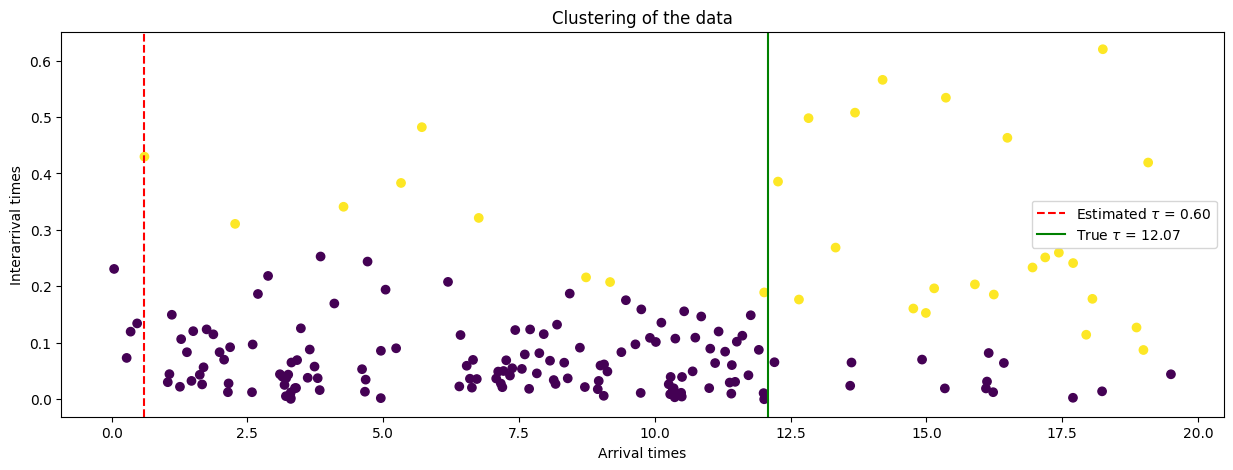

Estimated Tau: 0.6043017433326876


In [18]:



# Combine event times
event_times = time_interval[1]
inter_arrival_times = np.diff(event_times)

# Prepare data for clustering
data = np.array([[event_times[i], inter_arrival_times[i]] for i in range(len(inter_arrival_times))])

# Standardize the data
mean_data = np.mean(data, axis=0)
std_data = np.std(data, axis=0)
std_data = np.where(std_data == 0, 1, std_data)  # Avoid division by zero
standardized_data = (data - mean_data) / std_data

# Apply K-Means clustering to the data
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, random_state=666).fit(standardized_data)
labels = kmeans.labels_

# Estimate tau by finding the transition point
transition_index = np.where(labels[:-1] != labels[1:])[0][0] + 1
estimated_tau = event_times[transition_index]

# Plot the clusters
plt.figure(figsize=(15, 5))
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
plt.axvline(x=estimated_tau, color='r', linestyle='--', label=f'Estimated $\\tau$ = {estimated_tau:.2f}')
plt.axvline(x=tau, color='g', linestyle='-', label=f'True $\\tau$ = {tau:.2f}')
plt.xlabel('Arrival times')
plt.ylabel('Interarrival times')
plt.title('Clustering of the data')
plt.legend()
plt.show()

print('Estimated Tau:', estimated_tau)

**Comparaison of the results**

NB :this cell takes time

In [20]:
parameter_b = 1
parameter_a = list(range(5, 25))
n = 100
# comparing Z and Kmeans

error_hamming = []
error_kmeans = []
error_savgol = []
error_MLE = []
error_kde = []
for el in parameter_a :
    def f(t,y):
        return (h(t) - (parameter_b-el)*y)*(1-y)
    res , tau = combined_process(el, parameter_b, lambda1, T)
    times = res[1]
    Times , Z = solve(times, n, el, parameter_b)



    Z_filtered_hamm = np.convolve(Z, hamming(100)/sum(hamming(100)), mode='same')
    tau1 = Times[np.where(Z_filtered_hamm > 0.5)[0][0]]

    data = np.array([[times[i], 100*(times[i]-times[i-1])] for i in range(1, len(times))])
    kmeans = KMeans(n_clusters=2, init='k-means++' ,n_init=10 , random_state=666).fit(data)
    tau2 = Times[np.where(kmeans.labels_ == 1)[0][0]]

    Z_filtered_savgol = savgol_filter(Z, 801, 3)
    tau3 = Times[np.where(Z_filtered_savgol > 0.5)[0][0]]

    result = optimize.minimize_scalar(log_likelihood, bounds=(0, T), args=(times, el, parameter_b, T), method='bounded')
    tau_est = result.x


    times = generate_data(T, tau, el, parameter_b)
    density_estimation, kde = kde_estimation(times, bandwidth=1.0)
    time_points = np.linspace(0, T, 1000)
    density_derivative = np.gradient(density_estimation, time_points)
    smoothed_derivative = np.convolve(density_derivative, np.ones(10)/10, mode='same')
    estimated_tau = time_points[np.argmax(np.abs(smoothed_derivative))]
    tau4 = estimated_tau

    error_hamming.append(np.abs(tau - tau1))
    error_kmeans.append(np.abs(tau - tau2))
    error_savgol.append(np.abs(tau - tau3))
    error_kde.append(np.abs(tau - tau4))
    error_MLE.append(np.abs(tau - tau_est))

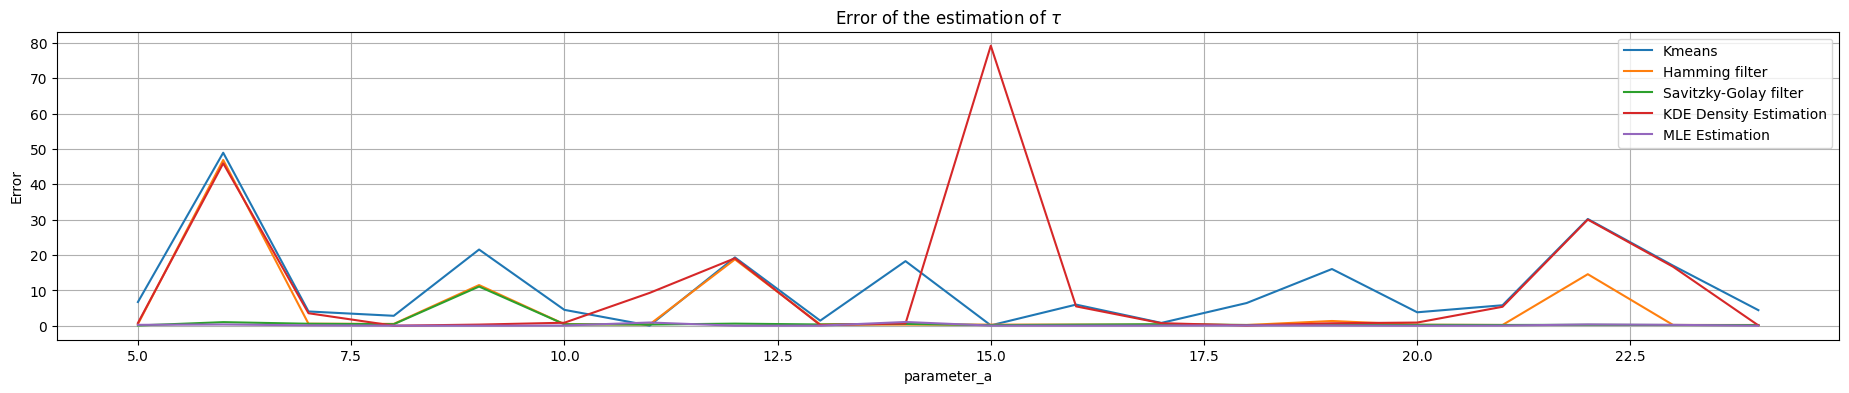

In [21]:
plt.figure(figsize=(23, 4))
plt.plot(parameter_a , error_kmeans , label = 'Kmeans')
plt.plot(parameter_a , error_hamming , label = 'Hamming filter')
plt.plot(parameter_a , error_savgol , label = 'Savitzky-Golay filter')
plt.plot(parameter_a , error_kde , label = 'KDE Density Estimation')
plt.plot(parameter_a , error_MLE , label = 'MLE Estimation')
plt.xlabel('parameter_a')
plt.ylabel('Error')
plt.title(r'Error of the estimation of $\tau$')
plt.legend()
plt.grid()
plt.show()

**Comment**

After comparing the five methods , we find that the filters and MLE method gives often a good estmation of $\tau$ , While KDE and Kmeans give results sometimes far from the real value of $\tau$.
we can optimize KDE by selecting an adaptive bandwidth that adjusts to local data density, and for K-means, we can pre-process the data with dimensionality reduction techniques or use time-aware clustering methods to better capture the temporal structure of Poisson process disruptions.